<a href="https://colab.research.google.com/github/Mv0sKff/MyDeepLearning/blob/main/week_8/Assignment_AE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

In [29]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor
train = dts.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test = dts.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [30]:
train[0][0].shape

torch.Size([1, 28, 28])

In [31]:
len(train)

60000

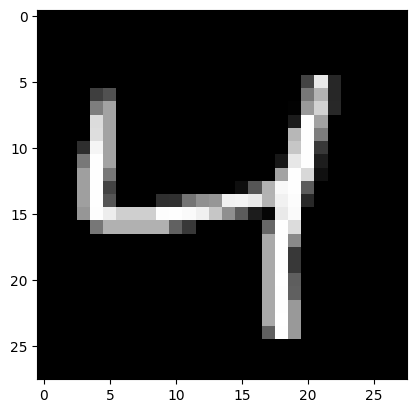

In [32]:
import matplotlib.pyplot as plt
plt.imshow(train[2][0].reshape((28,28)), cmap='gray')

## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html
* visualize some examples

In [33]:
import torch
#from torchvision.transforms import v2
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor()
])

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
aug_train = []

#for i in range(len(train)):
for i in range(10000):
    img, label = train[i]
    img = img.to(device)
    aug_img = transform(img)
    aug_img = aug_img.permute(1, 2, 0).squeeze()
    aug_img = aug_img.cpu()

    aug_train.append((aug_img, label))

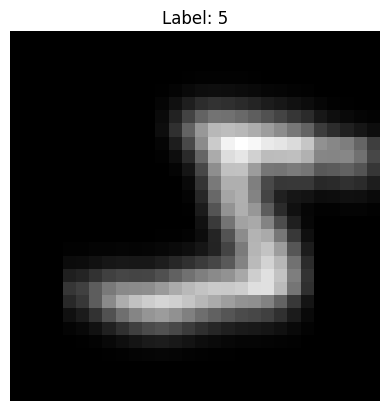

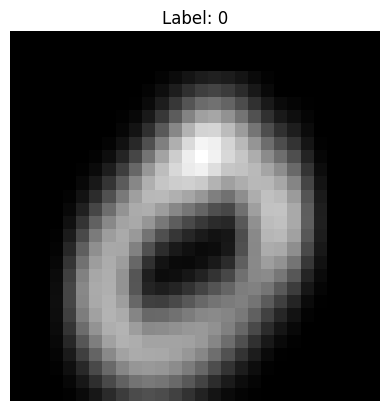

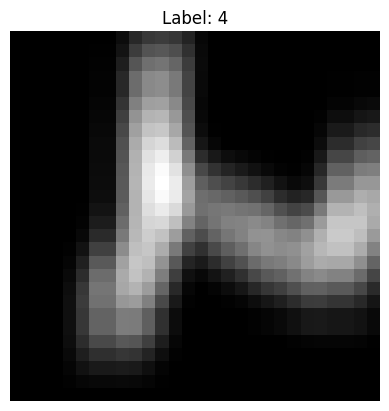

In [36]:
for i in range(3):
    img, label = train[i]
    aug_img, _ = aug_train[i]
    plt.imshow(aug_img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

## Exercise 2
Build and train a MLP Autoencoder with
* 2 Encoder Layers
* 2 Decoder Layers
* Identity Loss

In [37]:
import torch.nn as nn

class MLP_Autoencoder(nn.Module):
    def __init__(self):
        super(MLP_Autoencoder, self).__init__()

        input_size = 28 * 28

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(True),
            nn.Linear(1024, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [38]:
import torch.optim as optim

model = MLP_Autoencoder().to(device)
criterion = nn.MSELoss()  # Identity loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [39]:
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for imgs, _ in aug_train:
        imgs = imgs.view(-1).unsqueeze(0).to(device)  # (1, 784)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(aug_train):.4f}")


Epoch [1/5], Loss: 0.0134
Epoch [2/5], Loss: 0.0079
Epoch [3/5], Loss: 0.0069
Epoch [4/5], Loss: 0.0064
Epoch [5/5], Loss: 0.0061


## Exercise 3


Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

In [40]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

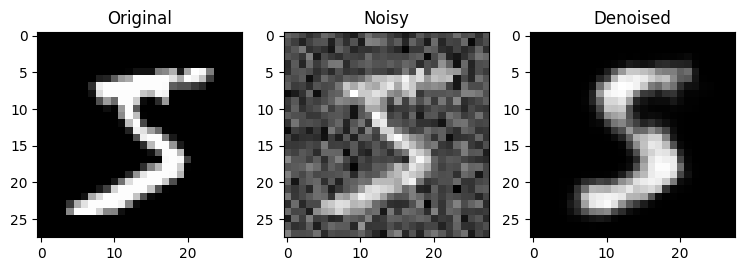

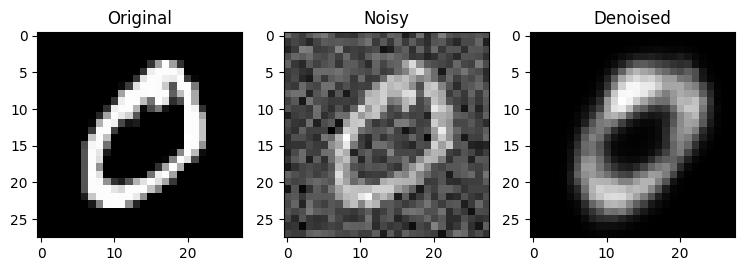

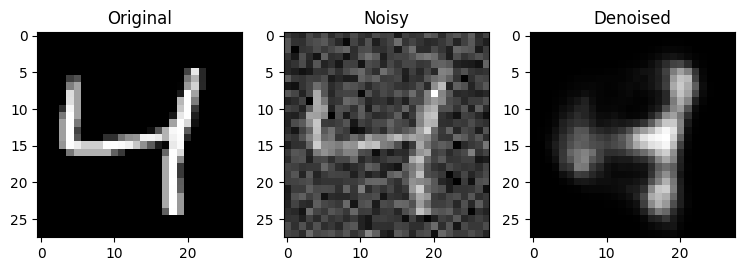

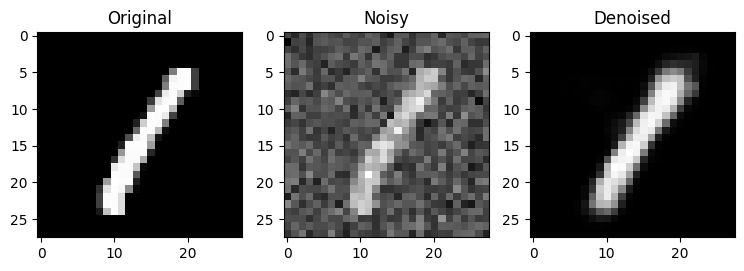

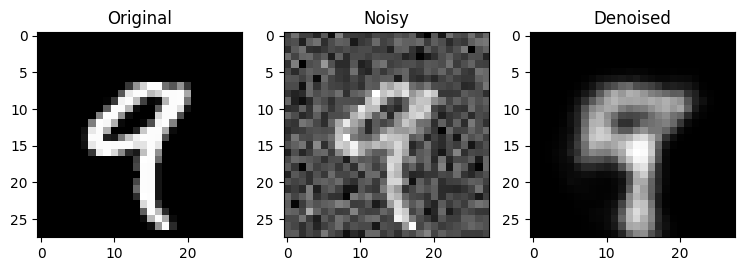

In [41]:
gaussian = AddGaussianNoise(0., 0.2)

for i in range(5):
    img, _ = train[i]
    noisy_img = gaussian(img).to(device)
    noisy_img_flat = noisy_img.view(-1).unsqueeze(0)

    with torch.no_grad():
        output = model(noisy_img_flat)
    output_img = output.view(28, 28).cpu()

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Original")
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img.squeeze().cpu(), cmap='gray')
    plt.title("Noisy")
    plt.subplot(1, 3, 3)
    plt.imshow(output_img, cmap='gray')
    plt.title("Denoised")
    plt.show()


## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (fron Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

# Get latent vectors
latent_vectors = []
labels = []

with torch.no_grad():
    for img, label in train:
        img = img.view(-1).unsqueeze(0).to(device)
        encoded = model.encoder(img)
        latent_vectors.append(encoded.cpu().numpy().squeeze())
        labels.append(label)

latent_vectors = np.array(latent_vectors)
labels = np.array(labels)

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors)

# Evaluate clustering
from sklearn.metrics import adjusted_rand_score, accuracy_score
ari = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
